<a href="https://colab.research.google.com/github/Khaled97Otour/Computer-aid-diagnostic-system-to-predict-and-extract-Lung-Cancer/blob/main/ECG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install keras

In [2]:
pip install tensorflow

In [3]:
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Conv1D, BatchNormalization,MaxPool1D, GlobalMaxPool1D
from keras.layers import TimeDistributed, GRU, Dense, Dropout, Masking, Embedding, LSTM ,Flatten
from keras.layers import Input, Conv1D, DepthwiseConv1D,\
     Dense, Concatenate, Add, ReLU, BatchNormalization, AvgPool1D, \
     MaxPool1D, GlobalAvgPool1D, Reshape, Permute, Lambda, Activation,RepeatVector
from keras import layers
from keras import models
import keras.backend as K
from keras.models import Model
import keras.backend as K
import random
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy, matplotlib
import csv
from scipy.fft import ifft,rfft

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
def Import_data(x,y):
  # read the files and build a dataset 
  # after processing the input signals
  rows = []
  rows1= []
  for row in x:
    rows.append(row)
  for row1 in y:
    rows1.append(row1)
  raw_normal_signals=np.asarray(rows)
  raw_Abnormal_signals=np.asarray(rows1)
  return raw_normal_signals,raw_Abnormal_signals


In [6]:
def signal_pre_processing(x,y):
  # in this function I use for loops to help me filtering the signals and delete the high frequnce noice
  # taking in mind the range of the signals and the length 
  s1=[]
  s2=[]
  l=x.shape[0]
  ll=y.shape[0]
  for i in range(l):
    b=scipy.fft.fft (x[i])
    for i in range(188):
      if b[i].real >=8:
        b[i]=0
      if b[i].real <=-8:
        b[i]=0
    b=scipy.fft.ifft(b)
    s1.append(b)
  for i in range(ll):
    B=scipy.fft.fft (y[i])
    for i in range(188) :
      if B[i].real >=8:
        B[i]=0
      if B[i].real <=-8:
        B[i]=0
    B=scipy.fft.ifft(B)
    s2.append(B)
  Normal_signals=np.asarray(s1)
  AbNormal_signals=np.asarray(s2)
  return Normal_signals,AbNormal_signals

In [7]:
def Do_dataset(x,y):
  # building dataset after cleaning all the signals and establish a dataframe as well as define a colume of labels.
  l=x.shape[0]
  ll=y.shape[0]
  number=[]
  signals=[]
  for i in range(l):
    signals.append(x[i])
    number.append(0)
  for i in range(ll):
    signals.append(y[i])
    number.append(1)
  numbers=np.asarray(number)
  # constructe dataset using data frame 
  my_series=pd.Series(data=signals,name='signals')
  data=pd.DataFrame(my_series)
  data['label']=numbers
  return data

In [8]:
def load_signal_label(x):
  signals = []
  label = []
  for i in range(len(x)):
    indexed_data = x.iloc[i]
    signals.append(indexed_data['signals'])
    label.append(indexed_data['label'])
  signals = np.asarray(signals)
  label = np.asarray(label)
  return signals, label

In [9]:
def data_gen(x,y):
  batch_signals = []
  batch_label = []
  for i in range(len(x)):
    sig=x[i]
    sig = np.expand_dims(sig, axis=-1)
    batch_signals.append(sig)
    labell =y[i]
    batch_label.append(labell)
  A=np.asarray(batch_signals)
  B=np.asarray(batch_label)
  return A, B

In [10]:
file = open(r'/content/drive/MyDrive/Colab Notebooks/ECG Signal /ptbdb_normal.csv')
csvreader = csv.reader(file)
file = open(r'/content/drive/MyDrive/Colab Notebooks/ECG Signal /ptbdb_abnormal.csv')
csvreader1 = csv.reader(file)

In [11]:
Normal,AbNormal= Import_data(csvreader,csvreader1)

In [12]:
normal,Abnormal= signal_pre_processing(Normal,AbNormal)

In [13]:
Dataset= Do_dataset(normal,Abnormal)
Signals, label= load_signal_label(Dataset)
xx_train_gen, yy_train_gen = data_gen(Signals, label)

In [14]:
Dataset

,signals,label
0,"[(0.8814269457646504+0j), (0.781751111585726+0...",0
1,"[(0.7626284556067053+0j), (0.5573099450743262+...",0
2,"[(0.746369916851573+0j), (0.628823060448222+0j...",0
3,"[(0.9268670122267956+0j), (0.4057603518607373+...",0
4,"[(0.8985901580172333+0j), (0.7658285007792267+...",0
...,...,...
14547,"[(0.8376090676923766+0j), (0.8562004120489136+...",1
14548,"[(0.5157839059733815+0j), (0.5206110217705371+...",1
14549,"[(0.760295179981915+0j), (0.6248058047966818+0...",1
14550,"[(0.7209435549110979+0j), (0.7022499980736757+...",1


In [15]:
print(xx_train_gen.shape)

(14552, 188, 1)


In [16]:
def action_model(shape=(188, 1), nbout=2):
    
    model= Sequential()

    model.add(Conv1D(32,3,input_shape=shape,strides=1,padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    #model.add(MaxPool1D(pool_size=2))
    #model.add(BatchNormalization())
    #model.add(Dropout(0.3))

    model.add(Conv1D(64,5,strides=1,padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Conv1D(128,7,input_shape=shape,strides=1,padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Conv1D(256,9,input_shape=shape,strides=1,padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    #model.add(MaxPool1D(pool_size=3))
    #model.add(BatchNormalization())
    #model.add(Dropout(0.3))
    
    model.add(Flatten())

    #model.add(Dense(512, activation='relu'))
    #model.add(BatchNormalization())
    #model.add(Dropout(0.5))

    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(nbout, activation='sigmoid'))
    return model

In [17]:
signal_dim = (188,1)
classes = 2
INPUT_SHAPE=signal_dim
model = action_model(INPUT_SHAPE, 2)
optimizer = tf.keras.optimizers.Adamax(0.0001)

In [18]:
model.compile(optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(xx_train_gen, yy_train_gen, validation_split=0.2, epochs =12, batch_size =32, verbose = 1, shuffle = 1)

Epoch 1/12
364/364 [==============================] - 21s 44ms/step - loss: 1.0736 - accuracy: 0.5365 - val_loss: 0.5992 - val_accuracy: 1.0000
Epoch 2/12
364/364 [==============================] - 15s 41ms/step - loss: 0.9096 - accuracy: 0.5878 - val_loss: 0.5815 - val_accuracy: 0.8966
Epoch 3/12
364/364 [==============================] - 15s 41ms/step - loss: 0.7747 - accuracy: 0.6334 - val_loss: 0.5762 - val_accuracy: 0.8193
Epoch 4/12
364/364 [==============================] - 15s 41ms/step - loss: 0.6629 - accuracy: 0.6834 - val_loss: 0.6443 - val_accuracy: 0.6510
Epoch 5/12
364/364 [==============================] - 15s 41ms/step - loss: 0.5526 - accuracy: 0.7395 - val_loss: 0.6405 - val_accuracy: 0.6812
Epoch 6/12
364/364 [==============================] - 15s 41ms/step - loss: 0.4649 - accuracy: 0.7813 - val_loss: 0.5022 - val_accuracy: 0.8543
Epoch 7/12
364/364 [==============================] - 15s 41ms/step - loss: 0.3771 - accuracy: 0.8313 - val_loss: 0.3422 - val_accuracy:

Text(0.5, 0, 'epoch')

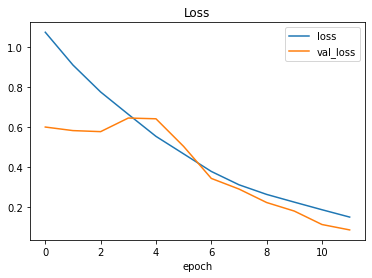

In [19]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.title('Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

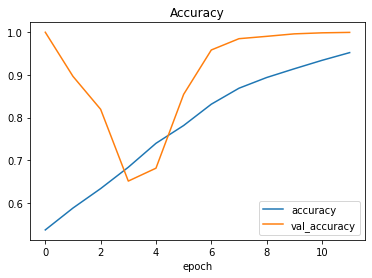

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy','val_accuracy'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [21]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 188, 32)           128       
                                                                 
 batch_normalization (BatchN  (None, 188, 32)          128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 188, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 188, 64)           10304     
                                                                 
 batch_normalization_1 (Batc  (None, 188, 64)          256       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 188, 64)           0

In [22]:
import json

# lets assume `model` is main model 
model_json = model.to_json()
with open("model_in_json_KHALED.json", "w") as json_file:
    json.dump(model_json, json_file)

model.save_weights("ECG_Model.h5")